## Prep Works

In [1]:
# Install necessary libraries
# !pip install imbalanced-learn
# !pip install xgboost
# !pip install scikit-learn
# !pip3 install --user --upgrade pandas

# Data handling and computation
import numpy as np
import pandas as pd
import itertools

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, PredefinedSplit, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

/Users/mu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/mu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# read csv
raw = pd.read_csv('UCSB_Capstone_cleaned_data.csv')

# drop non-numeric cols: 361*67
raw = raw.drop(columns = ['Unnamed: 0', 'assessment loc', 'Sex','Sport', 'Level', 'Name', 'assessmentDate'])

raw.head()

,Body Weight (kg),Height,reach,standingVertical1,doubleLegDrop1,Free Fall Force,Peak Loading Force,Peak Concentric Force,Imp1 Rel,Imp2 Rel,...,RotationAverage,MaxAnkleFlexionAssym,MaxKneeFlexionAssym,MaxHipFlexionAssym,maxLateralForce/kg,Injured,BackHamHistory,KneeHistory,LowerLegHistory,UpperLegHistory
0,96.6,77.5,102.5,128.0,127.0,4.713023,28.402888,31.092743,10.416413,22.360663,...,-9.015285,1.4969,2.5763,3.9136,9.996004,0,0,0,0,0
1,107.0,75.0,100.5,127.5,126.5,4.124252,20.769449,29.771009,12.532869,28.523692,...,-0.535422,3.0027,3.7041,0.0783,8.168752,0,0,0,0,0
2,94.7,80.0,105.0,137.0,134.5,2.964171,25.215533,28.732291,10.352413,22.957856,...,-10.266700,3.8158,0.1522,3.8700,10.031974,0,0,0,0,0
3,113.4,77.0,103.0,130.0,130.0,2.440794,19.271314,31.556499,13.508466,53.767284,...,-10.455300,0.7376,1.9444,0.6496,8.628504,0,0,0,0,0
4,103.3,80.0,107.0,135.0,133.5,0.733591,23.897135,28.867803,18.216825,54.860407,...,-4.974630,0.4100,0.2034,1.6443,8.504618,0,0,0,0,0


## Feature Selection

#### Find Highly Correlated Features

In [3]:
corr_pair = raw.corr().abs().unstack().sort_values(ascending=False)
corr_pair[(corr_pair < 1) & (corr_pair > 0.7)]

doubleLegDrop1                       standingVertical1                      0.965213
standingVertical1                    doubleLegDrop1                         0.965213
Height                               reach                                  0.930638
reach                                Height                                 0.930638
maxHipFlexionVelocityAvg             deltaHipFlexionAvg                     0.929582
deltaHipFlexionAvg                   maxHipFlexionVelocityAvg               0.929582
maxKneeExtensionVelocityAvg_x        maxKneeExtensionVelocityAvg_y          0.897332
maxKneeExtensionVelocityAvg_y        maxKneeExtensionVelocityAvg_x          0.897332
maxAnkleDorsiflexionVelocityAvg      maxAnkleDorsiflexionAccelerationAvg    0.879170
maxAnkleDorsiflexionAccelerationAvg  maxAnkleDorsiflexionVelocityAvg        0.879170
deltaHipFlexionAvg                   totalMovementTime_y                    0.869699
totalMovementTime_y                  deltaHipFlexionAvg          

#### Domain Knowledge Feature Selection(P3 Mentors)
* Filter out features from highly correlated pairs

In [4]:
# make DropJumpDisp and have it equal (doubleLegDrop1 - reach) then delete those two columns
raw['DropJumpDisp'] = raw['doubleLegDrop1'] - raw['reach']
drop_list = ['doubleLegDrop1', 'reach', 'maxKneeExtensionVelocityAvg_x', 'maxAnkleDorsiflexionAccelerationAvg',
            'maxHipExtensionAccelerationAvg', 'maxAnkleDorsiflexionVelocityAvg', 'maxAnkleDorsiflexionAccelerationAvg',
            'maxAnkleDorsiflexionAvg_x', 'hipTotalROMAvg', 'maxKneeExtensionAccelerationAvg', 'kneeTotalROMAvg',
            'standingVertical1', 'maxHipExtensionAvg_x', 'maxKneeFlexionVelocityAvg', 'maxKneeExtensionVelocityAvg_x',
            'maxKneeExtensionAccelerationAvg', 'maxAnkleDorsiflexionVelocityAvg', 'deltaAnkleDorsiflexionAvg',
            'maxKneeFlexionAvg_x']
raw = raw.drop(columns = drop_list)

raw.head()

,Body Weight (kg),Height,Free Fall Force,Peak Loading Force,Peak Concentric Force,Imp1 Rel,Imp2 Rel,Conc Rel,Inversion,Eversion,...,MaxAnkleFlexionAssym,MaxKneeFlexionAssym,MaxHipFlexionAssym,maxLateralForce/kg,Injured,BackHamHistory,KneeHistory,LowerLegHistory,UpperLegHistory,DropJumpDisp
0,96.6,77.5,4.713023,28.402888,31.092743,10.416413,22.360663,16.356273,10.4200,2.9600,...,1.4969,2.5763,3.9136,9.996004,0,0,0,0,0,24.5
1,107.0,75.0,4.124252,20.769449,29.771009,12.532869,28.523692,31.546738,16.5055,-20.0395,...,3.0027,3.7041,0.0783,8.168752,0,0,0,0,0,26.0
2,94.7,80.0,2.964171,25.215533,28.732291,10.352413,22.957856,16.297819,0.3320,-16.8445,...,3.8158,0.1522,3.8700,10.031974,0,0,0,0,0,29.5
3,113.4,77.0,2.440794,19.271314,31.556499,13.508466,53.767284,33.498713,3.6220,-14.2015,...,0.7376,1.9444,0.6496,8.628504,0,0,0,0,0,27.0
4,103.3,80.0,0.733591,23.897135,28.867803,18.216825,54.860407,27.696738,8.3165,-7.0850,...,0.4100,0.2034,1.6443,8.504618,0,0,0,0,0,26.5


#### Forward Greedy Algorithm on AUC
* Choose AUC to align with previous P3 studies

In [5]:
# Data loading and preprocessing
X = raw.drop('Injured', axis = 1)
y = raw['Injured']
all_features = X.columns.to_list()

# Initialize variables to track the best scores and best features
best_score = 0
best_features_selected = []

# Train-val-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.6, stratify=y_temp, random_state=0)


while True:
    scores = {}
    for feature in all_features:
        if feature not in best_features_selected:
            # Use currently selected best features plus a new candidate feature
            features_to_use = best_features_selected + [feature]
            X_train_subset = X_train[features_to_use]
            X_val_subset = X_val[features_to_use]
            X_test_subset = X_test[features_to_use]
            combo_best = 0
            smote = SMOTE(random_state=0, sampling_strategy=0.5)
            X_resampled, y_resampled = smote.fit_resample(X_train_subset, y_train)
            model = XGBClassifier(eval_metric = 'auc', random_state = 0)
            model.set_params(early_stopping_rounds = 10)
            model.fit(X_resampled, y_resampled, eval_set = [(X_val_subset, y_val)], verbose=False)
            # Evaluate model
            y_pred_prob = model.predict_proba(X_test_subset)[:, 1]
            score = roc_auc_score(y_test, y_pred_prob)
            if score > combo_best:
                combo_best = score
            scores[feature] = combo_best
                
    # Identify the feature that when added, results in the best increase in AUC
    best_new_feature, new_score = max(scores.items(), key=lambda x: x[1])

    # Check if the new score is better than the best score found so far
    if new_score > best_score:
        best_features_selected.append(best_new_feature)
        best_score = new_score
        print(f"Added features: {best_new_feature} - New best AUC: {best_score}")
    else:
        # Exit loop if no improvement
        print("No more improvement possible.")
        break

print("Best AUC:", best_score)
print("Best Features Set:", best_features_selected)

Added features: DropJumpDisp - New best AUC: 0.648989898989899
Added features: maxHipAbduction - New best AUC: 0.7373737373737375
Added features: MaxHipFlexionAssym - New best AUC: 0.751010101010101
Added features: KneeHistory - New best AUC: 0.7636363636363637
No more improvement possible.
Best AUC: 0.7636363636363637
Best Features Set: ['DropJumpDisp', 'maxHipAbduction', 'MaxHipFlexionAssym', 'KneeHistory']


**Problem**: Even though adding one feature doesn't improve model performance, adding 2, 3, or more might increase

#### Refined Greedy Algorithm
* Find the feature that resutls in most AUC improvement, if non single feature works, try adding different combination of 2 features and 3 features

In [6]:
X = raw.drop('Injured', axis = 1)
y = raw['Injured']

# Train-val-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.6, stratify=y_temp, random_state=0)


# Function to train model and calculate AUC
def evaluate_features(features):
    X_train_sub = X_train[list(features)]
    X_val_sub = X_val[list(features)]
    X_test_sub = X_test[list(features)]
    X_resampled, y_resampled = SMOTE(random_state=0, sampling_strategy = 0.5).fit_resample(X_train_sub, y_train)
    model = XGBClassifier(random_state=0, eval_metric='auc')
    model.set_params(early_stopping_rounds = 10)
    model.fit(X_resampled, y_resampled, eval_set = [(X_val_sub, y_val)], verbose=False)
    y_pred = model.predict_proba(X_test_sub)[:,1]
    return roc_auc_score(y_test, y_pred)

In [7]:
best_features_selected = []
best_score = 0
all_features = set(X.columns)

while True:
    current_best = None
    current_best_score = best_score
    
    # Try adding single features first
    for feature in all_features - set(best_features_selected):
        new_score = evaluate_features(best_features_selected + [feature])
        if new_score > current_best_score:
            current_best = [feature]
            current_best_score = new_score
    
    # If no single feature improves the model, try combinations of increasing size
    if not current_best:
        # at most combination of 3 due to computational power
        for r in range(2, 4):
            for combo in itertools.combinations(all_features - set(best_features_selected), r):
                new_score = evaluate_features(best_features_selected + list(combo))
                if new_score > current_best_score:
                    current_best = list(combo)
                    current_best_score = new_score
            if current_best:
                break
    
    # If a set of features improves the model, add them to the selected features
    if current_best:
        best_features_selected.extend(current_best)
        best_score = current_best_score
        print(f"Added features: {current_best} - New best AUC: {best_score}")
    else:
        # Exit if no improvement
        print("No more improvement possible.")
        break

        
print("Best AUC:", best_score)
print("Best Features Set:", best_features_selected)

Added features: ['DropJumpDisp'] - New best AUC: 0.648989898989899
Added features: ['maxHipAbduction'] - New best AUC: 0.7373737373737375
Added features: ['MaxHipFlexionAssym'] - New best AUC: 0.751010101010101
Added features: ['KneeHistory'] - New best AUC: 0.7636363636363637
Added features: ['Peak Concentric Force', 'maxHipActiveDecelerationAvg'] - New best AUC: 0.8328282828282828
Added features: ['maxHipExtensionVelocityAvg_y'] - New best AUC: 0.8797979797979798
Added features: ['maxHipAbductionVelocity', 'Body Weight (kg)'] - New best AUC: 0.8808080808080808
Added features: ['maxHipFlexion'] - New best AUC: 0.8954545454545455
Added features: ['maxKneeExtensionVelocityAvg_y', 'maxHipExtensionVelocity', 'Inversion'] - New best AUC: 0.906060606060606
No more improvement possible.
Best AUC: 0.906060606060606
Best Features Set: ['DropJumpDisp', 'maxHipAbduction', 'MaxHipFlexionAssym', 'KneeHistory', 'Peak Concentric Force', 'maxHipActiveDecelerationAvg', 'maxHipExtensionVelocityAvg_y', 

In [8]:
best_features = ['DropJumpDisp', 'maxHipAbduction', 'MaxHipFlexionAssym', 'KneeHistory',
                 'maxHipActiveDecelerationAvg', 'Peak Concentric Force', 'maxHipExtensionVelocityAvg_y',
                 'maxHipAbductionVelocity', 'Body Weight (kg)', 'maxHipFlexion', 'maxKneeExtensionVelocityAvg_y',
                 'Inversion', 'maxHipExtensionVelocity']

## Modeling

#### Parameter Tuning

In [9]:
best_score = 0
best_params = None

X = raw[best_features]
y = raw['Injured']

# Train-val-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.6, stratify=y_temp, random_state=0)

# Apply SMOTE only to the training data
for strategy in [0.25, 0.35, 0.4, 0.45, 0.5, 0.55]:
    smote = SMOTE(random_state = 0, sampling_strategy = strategy)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    for max_depth, learning_rate, n_estimators, subsample in itertools.product([3, 4, 5, 6, 7,8,9],
                                                                               [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
                                                                               [30, 50, 80,100, 150, 200, 250, 300],
                                                                               [0.7, 0.8, 0.9, 1]):
        model = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, subsample = subsample,
                              eval_metric='auc', random_state=0)
        model.set_params(early_stopping_rounds=10)
        model.fit(X_resampled, y_resampled, eval_set = [(X_val, y_val)], verbose=False)
        probabilities = model.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, probabilities)
        if score > best_score:
            best_score = score
            best_params = {'max_depth': max_depth, 'learning_rate': learning_rate,
                            'n_estimators': n_estimators, 'subsample': subsample,
                            'strategy': strategy}

print("Best Score:", best_score)
print("Best Parameters:", best_params)

Best Score: 0.908080808080808
Best Parameters: {'max_depth': 6, 'learning_rate': 0.25, 'n_estimators': 30, 'subsample': 1, 'strategy': 0.5}


#### Performance - with Injury History Features

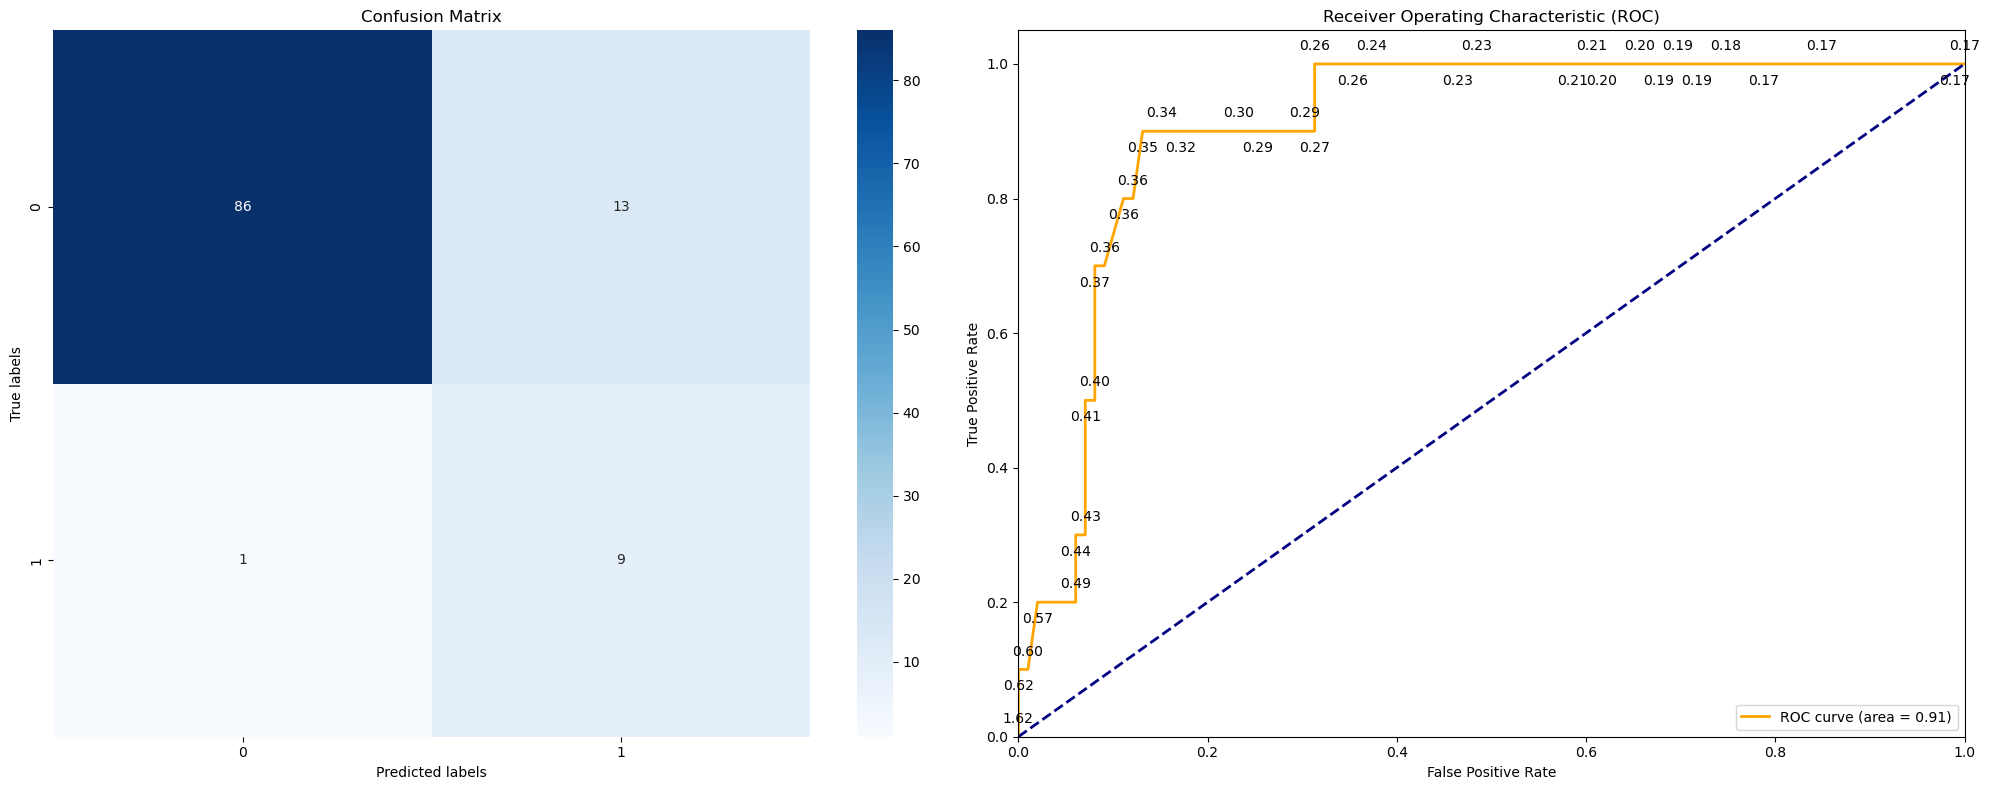

With Injury History:
AUC: 0.908080808080808
True Positive at 0.35456129908561707 threshold: 0.9
False Positive at 0.35456129908561707 threshold: 0.13131313131313133
Accuracy at 0.35456129908561707 threshold: 0.8715596330275229


In [10]:
X_hist = raw[best_features]
y_hist = raw['Injured']

# Train-val-test split
X_train_hist, X_temp_hist, y_train_hist, y_temp_hist = train_test_split(X_hist, y_hist, test_size = 0.5, stratify=y_hist, random_state=0)
X_val_hist, X_test_hist, y_val_hist, y_test_hist = train_test_split(X_temp_hist, y_temp_hist, test_size = 0.6, stratify=y_temp_hist, random_state=0)
X_resampled_hist, y_resampled_hist = SMOTE(random_state=0, sampling_strategy = 0.5).fit_resample(X_train_hist, y_train_hist)

    
optimal_model = XGBClassifier(eval_metric = 'auc',
                              random_state = 0,
                              max_depth = 6,
                              learning_rate = 0.25,
                              n_estimators = 30,
                              subsample = 1)

optimal_model.set_params(early_stopping_rounds = 10)
optimal_model.fit(X_resampled_hist, y_resampled_hist, eval_set = [(X_val_hist, y_val_hist)], verbose = False)


# Generate ROC curve data
fpr_hist, tpr_hist, thresholds_hist = roc_curve(y_test_hist, optimal_model.predict_proba(X_test_hist)[:, 1])
roc_auc_hist = auc(fpr_hist, tpr_hist)

# Generate the confusion matrix
best_threshold_hist = thresholds_hist[13]
y_pred_hist = (optimal_model.predict_proba(X_test_hist)[:, 1] >= best_threshold_hist).astype(int)
recall_hist = recall_score(y_test_hist, y_pred_hist)
cm_hist = confusion_matrix(y_test_hist, y_pred_hist)



# Create a figure with 1 row and 2 columns
plt.figure(figsize=(20, 8))

# Plotting the confusion matrix with seaborn
plt.subplot(1, 2, 1)
sns.heatmap(cm_hist, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Plotting the ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr_hist, tpr_hist, color='orange', lw=2, label=f'ROC curve (area = {roc_auc_hist:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate with threshold values
for i, threshold in enumerate(thresholds_hist):
    if i % 2 == 0:
        plt.annotate(f'{threshold:.2f}', (fpr_hist[i], tpr_hist[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    else:
        plt.annotate(f'{threshold:.2f}', (fpr_hist[i], tpr_hist[i]), textcoords="offset points", xytext=(0, -15), ha='center')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print('With Injury History:')
print(f'AUC: {roc_auc_hist}')
print(f'True Positive at {best_threshold_hist} threshold: {recall_hist}')
print(f'False Positive at {best_threshold_hist} threshold: {fpr_hist[thresholds_hist == best_threshold_hist][0]}')
print(f'Accuracy at {best_threshold_hist} threshold: {accuracy_score(y_test_hist, y_pred_hist)}')

#### Performance - without Injury History Features

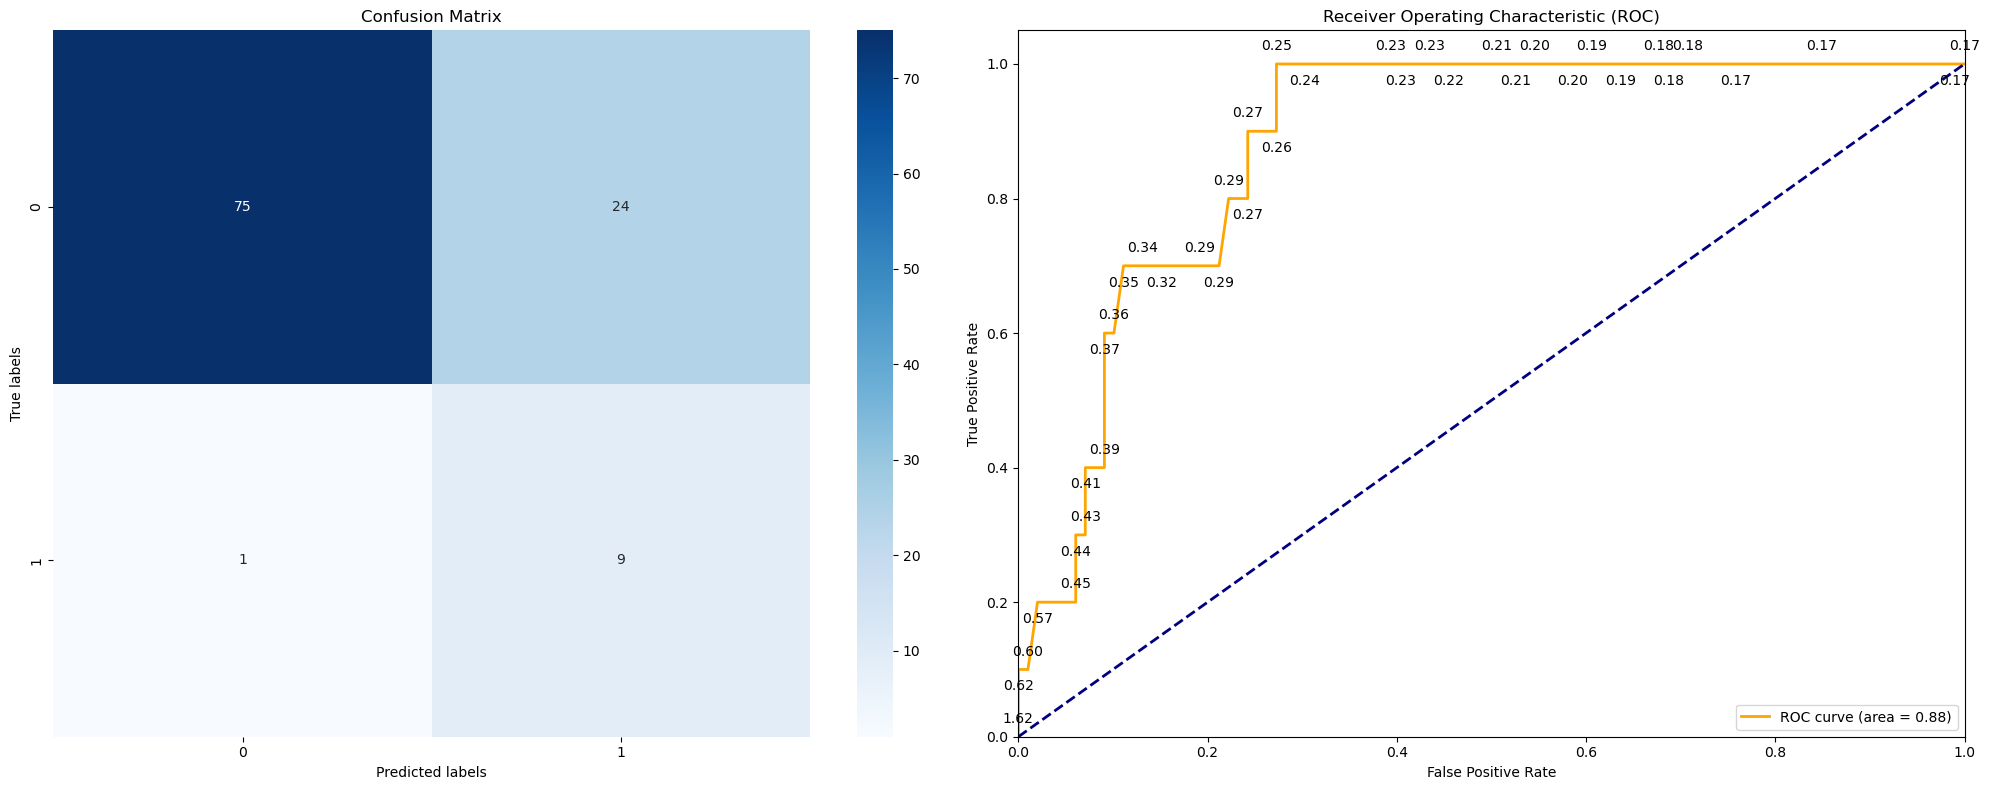

Without Injury History:
AUC: 0.8833333333333333
Recall at 0.2653445601463318 threshold: 0.9
False Positive at 0.2653445601463318 threshold: 0.24242424242424243
Accuracy at 0.2653445601463318 threshold: 0.7706422018348624


In [11]:
X = raw[best_features].drop('KneeHistory', axis = 1)
y = raw['Injured']

# Train-val-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.5, stratify=y, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.6, stratify=y_temp, random_state=0)
X_resampled, y_resampled = SMOTE(random_state=0, sampling_strategy = 0.5).fit_resample(X_train, y_train)

    
model_no_hist = XGBClassifier(eval_metric = 'auc',
                              random_state = 0,
                              max_depth = 6,
                              learning_rate = 0.25,
                              n_estimators = 30,
                              subsample = 1)

model_no_hist.set_params(early_stopping_rounds = 10)
model_no_hist.fit(X_resampled, y_resampled, eval_set = [(X_val, y_val)], verbose = False)


# Generate ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, model_no_hist.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)


# Generate the confusion matrix
threshold_ = thresholds[18]
y_pred = (model_no_hist.predict_proba(X_test)[:, 1] >=threshold_).astype(int)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20, 8))

# Plotting the confusion matrix with seaborn
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Plotting the ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate with threshold values
for i, threshold in enumerate(thresholds):
    if i % 2 == 0:
        plt.annotate(f'{threshold:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    else:
        plt.annotate(f'{threshold:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(0, -15), ha='center')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print('Without Injury History:')
print(f'AUC: {roc_auc}')
print(f'Recall at {threshold_} threshold: {recall}')
print(f'False Positive at {threshold_} threshold: {fpr[thresholds == threshold_][0]}')
print(f'Accuracy at {threshold_} threshold: {accuracy_score(y_test, y_pred)}')

**Sanity Check:** Without the injury history feature, even though the model performance drops a little bit, the model still has good overall performance, which means the injury history feature doesn't "take over" in making the prediction

Text(0.5, 0.47, 'Fig.2: Confusion matrix of the model with knee injury history features(0.35 thresholds)')

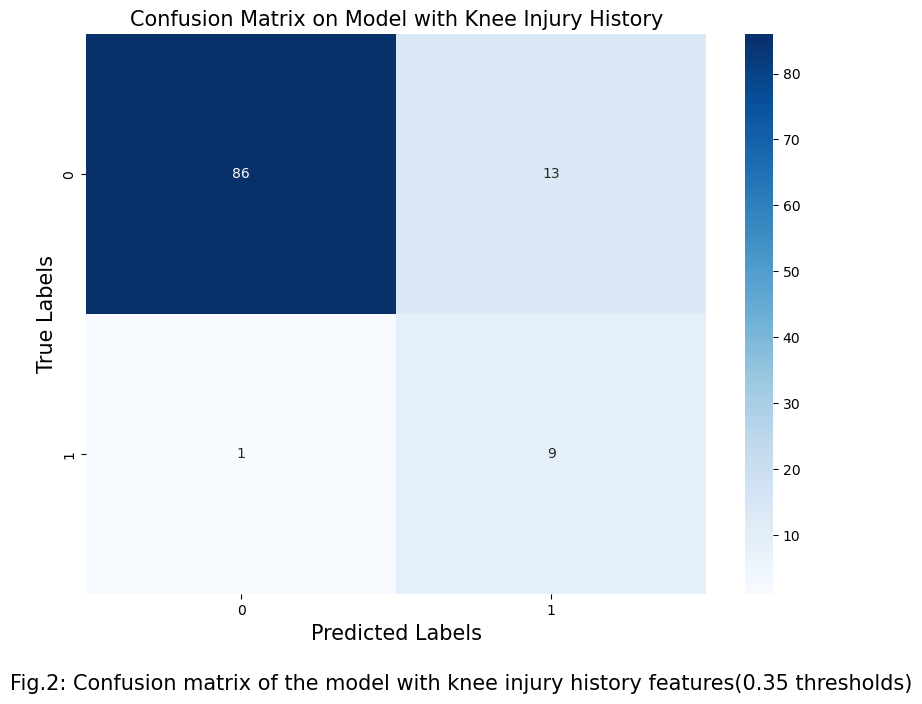

In [12]:
# Confusion Matrix for the model with Knee Injury History
y_pred_hist = (optimal_model.predict_proba(X_test_hist)[:, 1] >= best_threshold_hist).astype(int)
cm = confusion_matrix(y_test_hist, y_pred_hist)

plt.figure(figsize=(10, 16))

# Plot the Confusion Matrix
plt.subplot(2, 1, 1)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')  # 'g' ensures that float numbers are formatted to integers in heatmap
plt.title('Confusion Matrix on Model with Knee Injury History', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=15)
plt.ylabel('True Labels', fontsize=15)
plt.figtext(0.5, 0.47, "Fig.2: Confusion matrix of the model with knee injury history features(0.35 thresholds)",
            ha="center", fontsize=15, wrap=True)

# plt.savefig('confusion_matrix_with_injury_history.png', format='png', dpi=300, bbox_inches='tight')

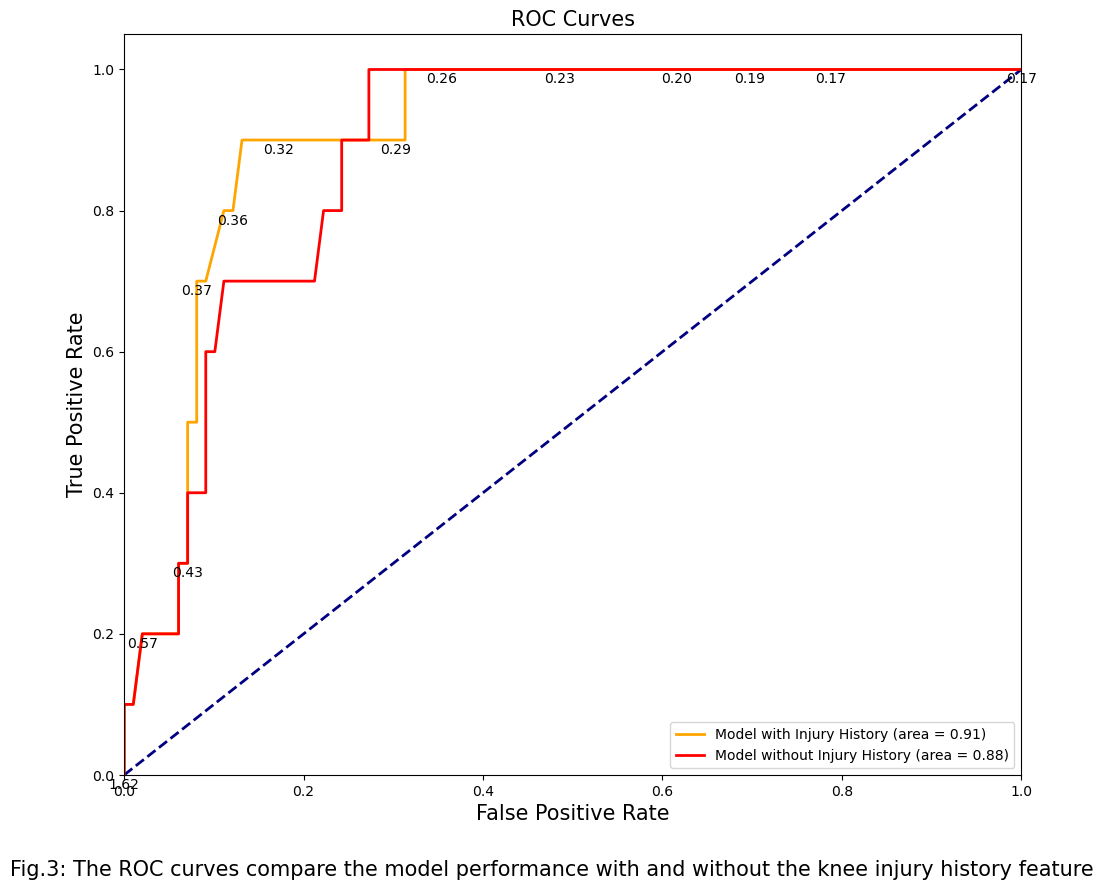

In [17]:
# ROC Curve Data for both models
fpr, tpr, thresholds = roc_curve(y_test_hist, optimal_model.predict_proba(X_test_hist)[:, 1])
roc_auc = auc(fpr, tpr)
fpr_no_hist, tpr_no_hist, thresholds_no_hist = roc_curve(y_test, model_no_hist.predict_proba(X_test)[:, 1])
roc_auc_no_hist = auc(fpr_no_hist, tpr_no_hist)

plt.figure(figsize=(10, 16))

# Plotting the ROC Curves
plt.subplot(2, 1, 2)  # Changed to second plot
plt.plot(fpr, tpr, color='orange', lw=2, label=f'Model with Injury History (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr_no_hist, tpr_no_hist, color='red', lw=2, label=f'Model without Injury History (area = {roc_auc_no_hist:.2f})')

# Annotate some thresholds
for i, threshold in enumerate(thresholds[::len(thresholds)//10]):
    plt.annotate(f'{threshold:.2f}', (fpr[i * (len(thresholds)//10)], tpr[i * (len(thresholds)//10)]), textcoords="offset points", xytext=(0,-10), ha='center')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.title('ROC Curves', fontsize = 15)
plt.legend(loc="lower right")
plt.figtext(0.5, -0.023, "Fig.3: The ROC curves compare the model performance with and without the knee injury history feature",
            ha="center", fontsize=15, wrap=True)
plt.tight_layout()

# plt.savefig('roc_curves_comparison.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

## Feature Importance by Information Gain: Optimal Model

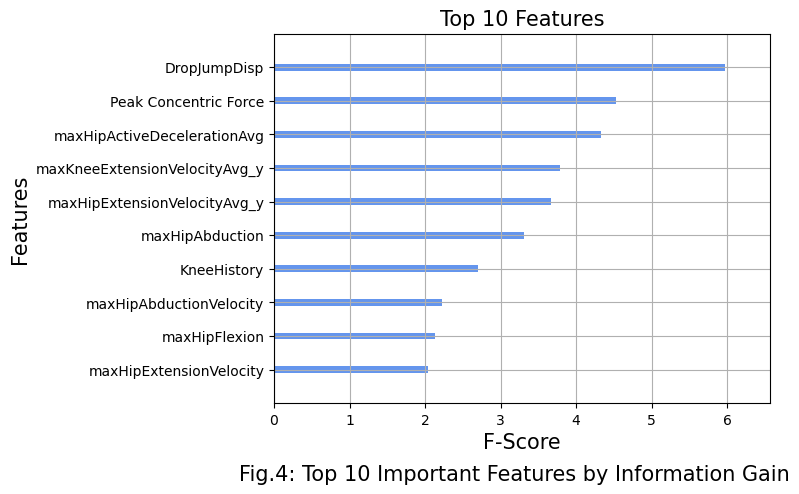

In [14]:
xgb.plot_importance(optimal_model, importance_type='gain', max_num_features = 10,
                    color='cornflowerblue', show_values=False)
plt.title('Top 10 Features', fontsize = 15)
plt.xlabel('F-Score', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.figtext(0.5, -0.05, "Fig.4: Top 10 Important Features by Information Gain", 
            wrap=True, horizontalalignment='center', fontsize=15)
plt.grid(True)

# plt.savefig('important_features.png', format='png', dpi=300, bbox_inches='tight')

# xgb.plot_importance(model, importance_type='weight', max_num_features = 10,
#                     color='cornflowerblue', show_values=True)
# plt.title('Feature Importance by Weight')
# plt.xlabel('Weight', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.yticks(fontsize=10)
# plt.xticks(fontsize=10)
# plt.grid(True)

# plt.show()